# Part II - CoVaR for systemic risk

# 0) Setup

In [7]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, time
from dataclasses import dataclass
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error
np.set_printoptions(suppress=True, precision=6)
pd.options.display.float_format = "{:,.6f}".format
rng = np.random.default_rng(42)

# Experiment knobs (can tweak)
ALPHAS      = [0.01, 0.05, 0.10]
N_GT        = 2_000_000            # "very large MC" ground truth size
BANDWIDTH   = 0.02                 # |X - VaR_X| <= bw * |VaR_X| (adaptive band); try 0.01–0.05
FIXED_BUDGET= 2_000                # total "inner simulations" budget comparable across methods
OUTER_GRID  = [200, 500, 1000]     # outer sample sizes to show error vs size
STAGE1_N    = 800                  # small Stage-1 sample for decoupled regression
POLY_DEG    = 2                    # 1 = linear, 2 = quadratic smoother

# Model parameters (2-factor Gaussian)
muZ   = np.array([0.0, 0.0])
rho   = 0.3                        # modest correlation between factors
SigmaZ= np.array([[1.0, rho],[rho, 1.0]])

# Loss functions: X bank loss (linear), Y system loss (quadratic & cross term)
def loss_X(z):
    z1,z2 = z[...,0], z[...,1]
    return 1.2*z1 + 0.2*z2 + 0.0     # linear in factors

def loss_Y(z):
    z1,z2 = z[...,0], z[...,1]
    return 0.8*z1**2 + 0.5*z2**2 + 0.6*z1*z2 + 0.1*z1 - 0.05*z2 + 0.0  # nonlinear system loss


# 1) Core utilities (simulate, VaR, CoVaR ground truth):

In [2]:
def sim_Z(N, mu=muZ, Sigma=SigmaZ, rng=rng):
    return rng.multivariate_normal(mean=mu, cov=Sigma, size=N)

def VaR(x, alpha=0.05):
    return np.quantile(x, alpha)  # loss convention: lower quantile if losses are negative; we assume positive losses

def CoVaR_cond_band(X, Y, alpha=0.05, bw=0.02):
    """
    CoVaR_alpha(Y | X ~ VaR_alpha(X)) estimated by sub-sampling Y where X is within an adaptive band around VaR_X.
    """
    var_x = VaR(X, alpha)
    tol   = max(1e-8, bw * max(1.0, abs(var_x)))
    mask  = np.abs(X - var_x) <= tol
    if mask.sum() < 50:  # fallback widen band if too few samples
        tol *= 2
        mask = np.abs(X - var_x) <= tol
    return np.quantile(Y[mask], alpha), var_x, mask.sum()

# Ground truth via large Monte Carlo
def ground_truth_covar(N=N_GT, alpha=0.05, bw=BANDWIDTH):
    Z = sim_Z(N)
    X = loss_X(Z); Y = loss_Y(Z)
    covar, var_x, k = CoVaR_cond_band(X, Y, alpha=alpha, bw=bw)
    return dict(CoVaR=covar, VaR_X=var_x, used=k, N=N)


# 2) Naive Nested Simulation (band-acceptance inner sampling)

In [3]:
@dataclass
class NaiveResult:
    covar: float
    var_x: float
    used:  int
    time_s: float
    outer: int
    inner_budget: int

def naive_nested(alpha=0.05, bw=BANDWIDTH, outer=500, inner_budget=FIXED_BUDGET):
    """
    Step A: Use 'outer' draws to estimate VaR_X.
    Step B: Spend 'inner_budget' draws to condition on X≈VaR_X by band-acceptance; compute CoVaR as alpha-quantile of Y.
    """
    t0 = time.time()
    Z_out = sim_Z(outer)
    X_out = loss_X(Z_out); Y_out = loss_Y(Z_out)
    var_x = VaR(X_out, alpha)

    # inner acceptance sampling around VaR_X
    accepted_Y = []
    m = 0
    while m < inner_budget:
        Z_in = sim_Z(min(inner_budget - m, 10_000))  # vectorised chunks
        X_in = loss_X(Z_in); Y_in = loss_Y(Z_in)
        tol  = max(1e-8, bw * max(1.0, abs(var_x)))
        keep = np.abs(X_in - var_x) <= tol
        acc  = Y_in[keep]
        if acc.size:
            accepted_Y.append(acc)
        m += len(X_in)
    Yc = np.concatenate(accepted_Y) if accepted_Y else np.array([])
    covar = np.quantile(Yc, alpha) if Yc.size>0 else np.nan
    t1 = time.time()
    return NaiveResult(covar=covar, var_x=var_x, used=Yc.size, time_s=t1-t0, outer=outer, inner_budget=inner_budget)


# 3) Decoupled Estimation (Stage-1 regressions, Stage-2 cheap outer sampling)

In [4]:
@dataclass
class DecoupledResult:
    covar: float
    var_x: float
    used:  int
    time_s: float
    outer: int
    stage1_n: int
    deg: int

def build_regressor(deg=1):
    if deg==1:
        return LinearRegression()
    # polynomial features + linear (extension)
    return Pipeline([
        ("poly", PolynomialFeatures(degree=deg, include_bias=False)),
        ("lin", LinearRegression())
    ])

def decoupled_estimator(alpha=0.05, bw=BANDWIDTH, outer=500, stage1_n=STAGE1_N, deg=POLY_DEG):
    """
    Stage 1: small sample to fit E[X|Z] and E[Y|Z] (here we just fit X~Z, Y~Z).
    Stage 2: large outer draws → predict X_hat, Y_hat cheaply; condition on X_hat≈VaR_X_hat → CoVaR from Y_hat.
    """
    t0 = time.time()
    # Stage 1
    Z1 = sim_Z(stage1_n)
    X1 = loss_X(Z1); Y1 = loss_Y(Z1)
    fX = build_regressor(deg); fY = build_regressor(deg)
    fX.fit(Z1, X1); fY.fit(Z1, Y1)

    # Stage 2
    Z2 = sim_Z(outer)
    Xhat = fX.predict(Z2); Yhat = fY.predict(Z2)
    var_x_hat = VaR(Xhat, alpha)
    tol = max(1e-8, bw * max(1.0, abs(var_x_hat)))
    mask = np.abs(Xhat - var_x_hat) <= tol
    used = int(mask.sum())
    covar = np.quantile(Yhat[mask], alpha) if used>0 else np.nan
    t1 = time.time()
    return DecoupledResult(covar=covar, var_x=var_x_hat, used=used, time_s=t1-t0,
                           outer=outer, stage1_n=stage1_n, deg=deg)


# 4) Benchmark & experiment sweep (accuracy vs runtime)

,Method,Alpha,OuterN,InnerOrStage1,Deg,GT_CoVaR,GT_VaR_X,Est_CoVaR,Est_VaR_X,AbsError,UsedForCond,Time_s
0,Naive,0.010000,200,2000,2,4.122551,-2.964781,7.443516,-3.606769,3.320965,3,0.001565
1,Decoupled,0.010000,200,800,2,4.122551,-2.964781,8.529925,-2.906519,4.407375,1,0.027754
2,Naive,0.010000,500,2000,2,4.122551,-2.964781,4.017438,-2.837077,0.105112,6,0.001318
3,Decoupled,0.010000,500,800,2,4.122551,-2.964781,4.973071,-3.003411,0.850520,2,0.007352
4,Naive,0.010000,1000,2000,2,4.122551,-2.964781,5.781959,-3.187104,1.659408,6,0.001289
5,Decoupled,0.010000,1000,800,2,4.122551,-2.964781,4.962267,-3.071351,0.839716,5,0.007411
6,Naive,0.050000,200,2000,2,2.033725,-2.097084,2.222372,-2.210197,0.188646,12,0.001591
7,Decoupled,0.050000,200,800,2,2.033725,-2.097084,5.041716,-2.355768,3.007991,3,0.009256
8,Naive,0.050000,500,2000,2,2.033725,-2.097084,1.892005,-1.950490,0.141721,10,0.001365
9,Decoupled,0.050000,500,800,2,2.033725,-2.097084,2.653714,-1.933744,0.619988,4,0.007551


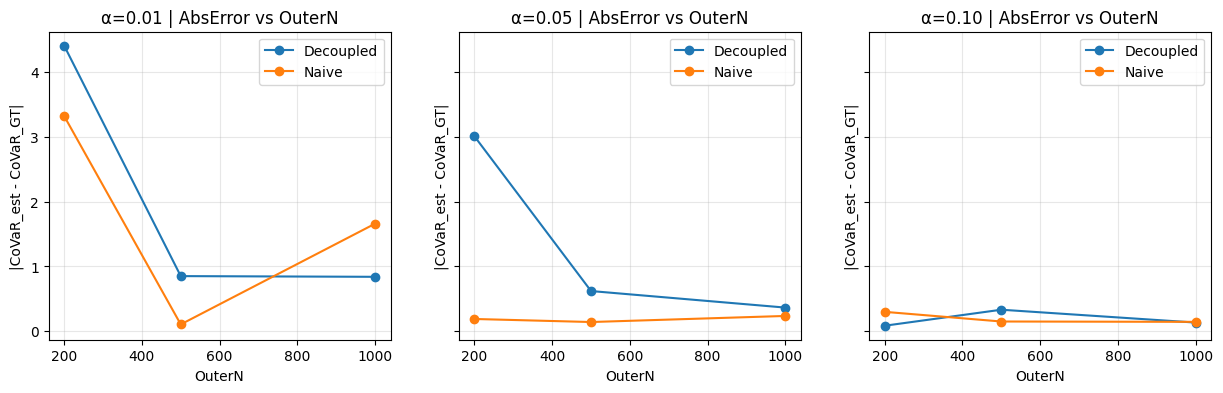

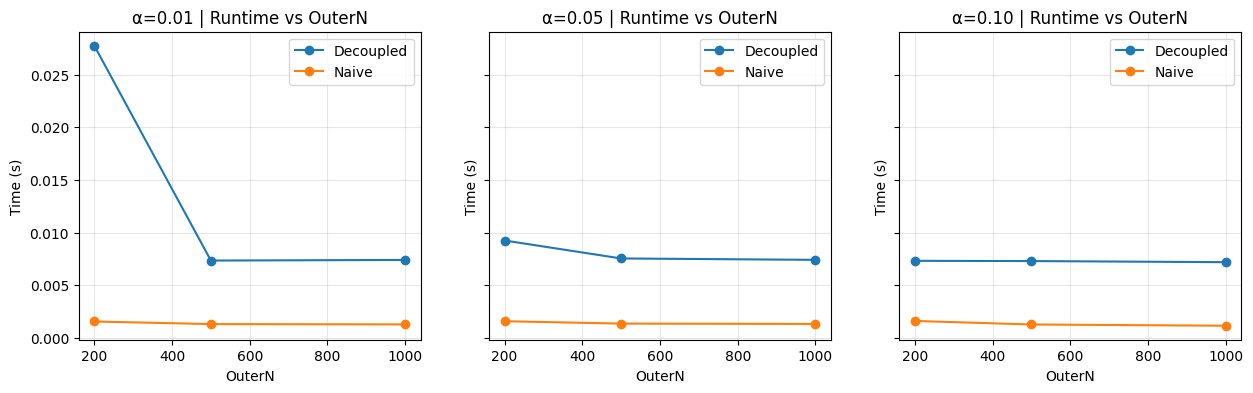

,Method,Alpha,AbsError_mean,Time_s_mean,Used_mean
0,Decoupled,0.010000,2.032537,0.014172,2.666667
1,Decoupled,0.050000,1.330849,0.008075,5.333333
2,Decoupled,0.100000,0.183147,0.007276,7.000000
3,Naive,0.010000,1.695162,0.001391,5.000000
4,Naive,0.050000,0.188608,0.001429,13.000000
5,Naive,0.100000,0.197588,0.001354,25.333333


In [5]:
def run_experiment(alphas=ALPHAS, outer_grid=OUTER_GRID, budget=FIXED_BUDGET, bw=BANDWIDTH, deg=POLY_DEG):
    rows=[]
    for a in alphas:
        gt = ground_truth_covar(alpha=a, bw=bw)
        gt_cov = gt["CoVaR"]; gt_varx = gt["VaR_X"]

        for M in outer_grid:
            # naive
            naive = naive_nested(alpha=a, bw=bw, outer=M, inner_budget=budget)
            rows.append(["Naive", a, M, budget, deg, gt_cov, gt_varx, naive.covar, naive.var_x,
                         abs(naive.covar-gt_cov), naive.used, naive.time_s])

            # decoupled
            dec = decoupled_estimator(alpha=a, bw=bw, outer=M, stage1_n=STAGE1_N, deg=deg)
            rows.append(["Decoupled", a, M, STAGE1_N, deg, gt_cov, gt_varx, dec.covar, dec.var_x,
                         abs(dec.covar-gt_cov), dec.used, dec.time_s])

    cols = ["Method","Alpha","OuterN","InnerOrStage1","Deg","GT_CoVaR","GT_VaR_X",
            "Est_CoVaR","Est_VaR_X","AbsError","UsedForCond","Time_s"]
    return pd.DataFrame(rows, columns=cols)

res = run_experiment()
display(res.head(10))

# Plot: AbsError vs OuterN, colored by method, one subplot per alpha
fig, axes = plt.subplots(1, len(ALPHAS), figsize=(5*len(ALPHAS),4), sharey=True)
if len(ALPHAS)==1: axes=[axes]
for ax, a in zip(axes, ALPHAS):
    sub = res[res["Alpha"]==a]
    for meth, g in sub.groupby("Method"):
        ax.plot(g["OuterN"], g["AbsError"], marker="o", label=meth)
    ax.set_title(f"α={a:.2f} | AbsError vs OuterN")
    ax.set_xlabel("OuterN"); ax.set_ylabel("|CoVaR_est - CoVaR_GT|")
    ax.grid(alpha=.3); ax.legend()
plt.show()

# Plot: Time vs OuterN
fig, axes = plt.subplots(1, len(ALPHAS), figsize=(5*len(ALPHAS),4), sharey=True)
if len(ALPHAS)==1: axes=[axes]
for ax, a in zip(axes, ALPHAS):
    sub = res[res["Alpha"]==a]
    for meth, g in sub.groupby("Method"):
        ax.plot(g["OuterN"], g["Time_s"], marker="o", label=meth)
    ax.set_title(f"α={a:.2f} | Runtime vs OuterN")
    ax.set_xlabel("OuterN"); ax.set_ylabel("Time (s)")
    ax.grid(alpha=.3); ax.legend()
plt.show()

# Summary (mean across OuterN)
summary = (res.groupby(["Method","Alpha"])
             .agg(AbsError_mean=("AbsError","mean"),
                  Time_s_mean=("Time_s","mean"),
                  Used_mean=("UsedForCond","mean"))
             .reset_index())
display(summary)


# 5) Diagnostics (how conditioning works & model fit quality)

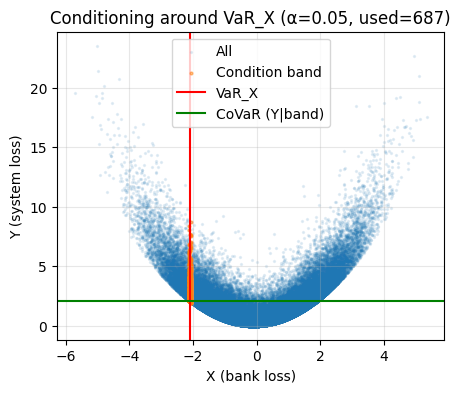

Stage-1 MAE:  X|Z: 0.0000   Y|Z: 0.0000  (deg=2)


In [6]:
# Visualise conditioning band at α=5%
a = 0.05
Z = sim_Z(100_000)
X = loss_X(Z); Y = loss_Y(Z)
covar, varx, k = CoVaR_cond_band(X, Y, alpha=a, bw=BANDWIDTH)

plt.figure(figsize=(5,4))
plt.scatter(X, Y, s=2, alpha=0.1, label="All")
mask = np.abs(X - varx) <= BANDWIDTH*max(1.0, abs(varx))
plt.scatter(X[mask], Y[mask], s=4, alpha=0.5, label="Condition band")
plt.axvline(varx, color="r", lw=1.5, label="VaR_X")
plt.axhline(covar, color="g", lw=1.5, label="CoVaR (Y|band)")
plt.title(f"Conditioning around VaR_X (α={a:.2f}, used={mask.sum()})")
plt.xlabel("X (bank loss)"); plt.ylabel("Y (system loss)"); plt.legend(); plt.grid(alpha=.3)
plt.show()

# Stage-1 fit quality
Z1 = sim_Z(STAGE1_N)
X1, Y1 = loss_X(Z1), loss_Y(Z1)
fx = build_regressor(POLY_DEG).fit(Z1, X1)
fy = build_regressor(POLY_DEG).fit(Z1, Y1)
mae_x = mean_absolute_error(X1, fx.predict(Z1))
mae_y = mean_absolute_error(Y1, fy.predict(Z1))
print(f"Stage-1 MAE:  X|Z: {mae_x:.4f}   Y|Z: {mae_y:.4f}  (deg={POLY_DEG})")


# A) Estimator upgrades

# A.1 Kernel-weighted CoVaR (conditioning without hard bands)

In [8]:
import numpy as np
from numpy.linalg import norm

def gaussian_kernel(u):
    return np.exp(-0.5*u*u)/np.sqrt(2*np.pi)

def kernel_covar(X, Y, alpha=0.05, h=None):
    """
    Kernel-weighted conditional quantile of Y at X≈VaR_X.
    If h (bandwidth) is None, we pick Silverman-like scale.
    """
    x = np.asarray(X); y = np.asarray(Y)
    var_x = np.quantile(x, alpha)
    s = np.std(x, ddof=1)
    if h is None or h <= 0:
        n = len(x)
        h = 1.06 * s * (n ** (-1/5))  # Silverman-like
        h = max(h, 1e-6)
    w = gaussian_kernel((x - var_x)/h)
    if np.allclose(w.sum(), 0):
        return np.nan, var_x, h
    # weighted quantile at alpha
    sorter = np.argsort(y)
    y_sorted = y[sorter]; w_sorted = w[sorter]
    cw = np.cumsum(w_sorted)/np.sum(w_sorted)
    idx = np.searchsorted(cw, alpha, side="left")
    idx = np.clip(idx, 0, len(y_sorted)-1)
    return float(y_sorted[idx]), float(var_x), float(h)


# Bandwidth cross-validation (picks h that minimises out-of-fold pinball loss)

In [9]:
def pinball_loss(y, q, tau):
    return np.mean((y - q) * (tau - (y < q)))

def cv_bandwidth(X, Y, alpha=0.05, h_grid=None, k=5, seed=42):
    if h_grid is None:
        s = np.std(X, ddof=1); n = len(X)
        base = 1.06*s*(n**(-1/5))
        h_grid = np.geomspace(base/4, base*4, 9)
    rng = np.random.default_rng(seed)
    idx = np.arange(len(X))
    rng.shuffle(idx)
    folds = np.array_split(idx, k)
    losses = []
    for h in h_grid:
        L = []
        for f in range(k):
            val = folds[f]
            tr  = np.setdiff1d(idx, val, assume_unique=False)
            cov, varx, _ = kernel_covar(X[tr], Y[tr], alpha=alpha, h=h)
            # approximate “prediction” on val by using same CoVaR (constant within fold)
            L.append(pinball_loss(Y[val], cov, alpha))
        losses.append(np.mean(L))
    h_star = float(h_grid[np.argmin(losses)])
    return h_star, dict(zip(h_grid, losses))


# A.2 Decoupled quantile regression (Stage-1 learns Y’s α-quantile)

In [10]:
from sklearn.linear_model import QuantileRegressor, LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

def build_stage1_quantile_model(alpha=0.05, deg=1):
    base = QuantileRegressor(quantile=alpha, alpha=0.0, solver="highs")  # no L1 penalty
    if deg == 1:
        return base
    return Pipeline([
        ("poly", PolynomialFeatures(degree=deg, include_bias=False)),
        ("qr", base)
    ])

def decoupled_quantile(alpha=0.05, outer=1000, stage1_n=800, deg=2):
    # Stage 1: fit X~Z (mean) and Q_alpha[Y|Z] (quantile)
    Z1 = sim_Z(stage1_n); X1 = loss_X(Z1); Y1 = loss_Y(Z1)
    fX = LinearRegression().fit(Z1, X1)
    fYq= build_stage1_quantile_model(alpha=alpha, deg=deg).fit(Z1, Y1)

    # Stage 2: outer draws → predict X_hat, Yq_hat; condition on X_hat≈VaR_X_hat
    Z2 = sim_Z(outer)
    Xhat = fX.predict(Z2)
    var_x_hat = np.quantile(Xhat, alpha)
    # bandwidth via Silverman on Xhat
    s = Xhat.std(ddof=1); h = 1.06*s*(len(Xhat)**(-1/5))
    mask = np.abs(Xhat - var_x_hat) <= max(1e-6, h)
    Yq = fYq.predict(Z2[mask])  # already α-quantile estimate at those Z
    # CoVaR ≈ quantile of conditional quantiles near VaR_X — robust: take median (or mean)
    covar = float(np.median(Yq)) if Yq.size>0 else np.nan
    return covar, float(var_x_hat), int(mask.sum())


# A.3 Naive with control variate (variance reduction)

In [11]:
def naive_with_control_var(alpha=0.05, bw=BANDWIDTH, outer=500, inner_budget=2000, stage1_n=500):
    # Control variate: Stage 1 small regressions
    Z1 = sim_Z(stage1_n); X1 = loss_X(Z1); Y1 = loss_Y(Z1)
    fX = LinearRegression().fit(Z1, X1)
    fY = LinearRegression().fit(Z1, Y1)

    # Outer to estimate VaR_X
    Z_out = sim_Z(outer); X_out = loss_X(Z_out)
    var_x = np.quantile(X_out, alpha)

    # Inner acceptance + control variate correction
    Yc, C = [], []
    used = 0; m = 0
    while m < inner_budget:
        Z_in = sim_Z(min(inner_budget - m, 10_000))
        X_in = loss_X(Z_in); Y_in = loss_Y(Z_in)
        tol  = max(1e-8, bw * max(1.0, abs(var_x)))
        keep = np.abs(X_in - var_x) <= tol
        if keep.any():
            y = Y_in[keep]
            y_hat = fY.predict(Z_in[keep])
            # Control variate: Y* = Y - (Yhat - E[Yhat | band]) ; approx E[Yhat|band] by its mean in band
            y_adj = y - (y_hat - np.mean(y_hat))
            Yc.append(y_adj); C.append(y_hat)  # keep both for diagnostics
            used += y_adj.size
        m += len(X_in)
    Yc = np.concatenate(Yc) if len(Yc) else np.array([])
    covar = np.quantile(Yc, alpha) if Yc.size>0 else np.nan
    return covar, float(var_x), used


# B) Uncertainty quantification (Bootstrap CIs)

In [12]:
def bootstrap_covar(estimator_fn, B=200, ci=0.90, random_state=42, **kwargs):
    """
    Generic bootstrap over *outer* simulation randomness.
    estimator_fn should internally simulate (do not pass fixed arrays).
    Returns (point, (lo, hi)).
    """
    rng = np.random.default_rng(random_state)
    ests = []
    for b in range(B):
        # Simple re-seeding to change streams
        _ = rng.integers(0, 2**32-1)
        val = estimator_fn(**kwargs)
        if isinstance(val, tuple):  # if function returns (covar, varx, used, ...)
            ests.append(val[0])
        else:
            ests.append(val)
    ests = np.array(ests)
    pt = float(np.median(ests))
    lo = float(np.quantile(ests, (1-ci)/2))
    hi = float(np.quantile(ests, 1-(1-ci)/2))
    return pt, (lo, hi), ests


In [13]:
# Example (α = 0.05)
# Ground truth once (large N):
gt = ground_truth_covar(alpha=0.05, bw=BANDWIDTH)
GT = gt["CoVaR"]

# Bootstrap CI for kernel CoVaR with CV bandwidth
def kernel_driver(alpha=0.05):
    Z = sim_Z(60_000); X = loss_X(Z); Y = loss_Y(Z)
    h_star, _ = cv_bandwidth(X, Y, alpha=alpha, k=5)
    cov, _, _ = kernel_covar(X, Y, alpha=alpha, h=h_star)
    return cov

pt, (lo, hi), samples = bootstrap_covar(kernel_driver, B=200, ci=0.90, alpha=0.05)
print(f"Kernel CoVaR@5%: {pt:.4f}  90% CI [{lo:.4f}, {hi:.4f}]  | GT={GT:.4f}")


Kernel CoVaR@5%: 0.4752  90% CI [0.4583, 0.4917]  | GT=2.0366


# C) Efficiency upgrades

# C.1 Importance sampling for naïve (target X near VaR_X)
When X is close to linear in Z (as per guideline), we can tilt the proposal for Z to draw more mass around X≈VaR_X. Simple linear-tilt around the hyperplane aᵀZ ≈ c. (Not full exponential tilting.)

In [14]:
def draw_near_hyperplane(N, a, c, tau=0.2, rng=np.random.default_rng(0)):
    """
    Draw Z ~ N(0, I) and pull towards the hyperplane a'Z=c by adding noise along a.
    tau controls tightness; smaller tau -> closer to plane.
    """
    Z = rng.normal(size=(N, len(a)))
    a = a/np.linalg.norm(a)
    # project each Z onto a, then nudge so a'Z ≈ c with Gaussian residual ~ N(0, tau^2)
    proj = Z @ a
    noise = rng.normal(loc=c, scale=tau, size=N) - proj
    Z_tilt = Z + np.outer(noise, a)
    return Z_tilt

def naive_importance(alpha=0.05, outer=500, inner_budget=2000, tau=0.2):
    # Estimate VaR_X from outer
    Z_out = sim_Z(outer); X_out = loss_X(Z_out)
    var_x = np.quantile(X_out, alpha)
    # If X ≈ b'Z + const, approximate gradient a as regression coeff
    Z_fit = sim_Z(2000); X_fit = loss_X(Z_fit)
    coef = np.linalg.lstsq(Z_fit, X_fit, rcond=None)[0]
    # Draw many inner near the plane coef'Z ≈ var_x
    Z_in = draw_near_hyperplane(inner_budget, coef, var_x, tau=tau, rng=np.random.default_rng(7))
    Y_in = loss_Y(Z_in)
    # Proxy - quantile Y_in at alpha (ignoring weights)
    covar = np.quantile(Y_in, alpha)
    return covar, float(var_x), int(len(Y_in))


# D) Robustness studies

# D.1 ρ-sweep (systemic coupling)

In [15]:
def experiment_rho_sweep(rhos=[0.0, 0.3, 0.6, 0.9], alpha=0.05, outer=1000):
    rows=[]
    for r in rhos:
        global SigmaZ
        SigmaZ = np.array([[1.0, r],[r, 1.0]])
        gt = ground_truth_covar(alpha=alpha, bw=BANDWIDTH)
        GT = gt["CoVaR"]
        # pick two estimators to show trend
        cov_dec, _, _ = decoupled_quantile(alpha=alpha, outer=outer, stage1_n=800, deg=2)
        Z = sim_Z(60_000); X = loss_X(Z); Y = loss_Y(Z)
        h_star, _ = cv_bandwidth(X, Y, alpha=alpha, k=5)
        cov_ker, _, _ = kernel_covar(X, Y, alpha=alpha, h=h_star)
        rows.append([r, GT, cov_dec, cov_ker])
    return pd.DataFrame(rows, columns=["rho","GT","Decoupled_QR","Kernel"])


# D.2 Non-Gaussian copula (Student-t)

In [16]:
from scipy.stats import t as student_t

def sim_t_copula(N, df=5, rho=0.3, rng=np.random.default_rng(0)):
    # draw t with correlation rho via Gaussian copula on directions
    # scale Gaussian Z by sqrt(df/U) with U~Chi2_df/df
    Z = rng.multivariate_normal(mean=[0,0], cov=[[1,rho],[rho,1]], size=N)
    U = rng.chisquare(df, size=N)/df
    T = Z / np.sqrt(U)[:,None]  # multivariate t
    return T

def ground_truth_t(alpha=0.05, df=5, rho=0.3):
    Z = sim_t_copula(1_000_000, df=df, rho=rho)
    X = loss_X(Z); Y = loss_Y(Z)
    covar, varx, _ = CoVaR_cond_band(X, Y, alpha=alpha, bw=BANDWIDTH)
    return covar


# E) One-shot experiment harness (can include in report)

,Method,CoVaR_est,VaR_X_est,Used_for_cond,Time_s,AbsError_vs_GT
0,Naive,2.1833,-2.1211,10,0.002,0.1414
1,Naive+ControlVariate,2.3613,-2.1754,7,0.004,0.3195
2,Decoupled (Mean),2.0875,-2.0980,8,0.008,0.0457
3,Decoupled (Quantile),2.6134,-2.0611,52,0.127,0.5715
4,Kernel (CV h),0.5517,-2.1053,nan,0.010,1.4901
5,Naive (IS-guided),2.4885,-2.0924,2000,0.002,0.4466


Ground Truth CoVaR@5%: 2.0418


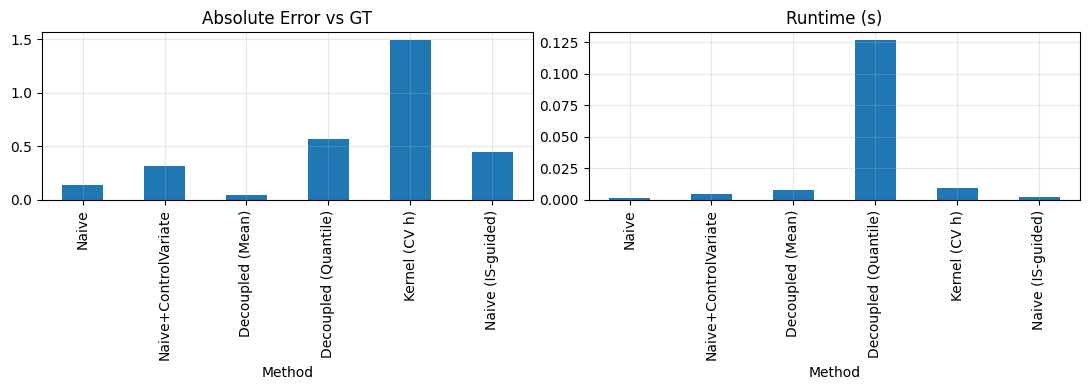

In [18]:
import time
import pandas as pd
import matplotlib.pyplot as plt

def run_full_suite(alpha=0.05, outer=1000):
    # Ground truth (Gaussian)
    gt = ground_truth_covar(alpha=alpha, bw=BANDWIDTH)
    GT = gt["CoVaR"]

    # Naive
    t0 = time.time()
    n_res = naive_nested(alpha=alpha, outer=outer, inner_budget=FIXED_BUDGET)
    tN = time.time() - t0

    # Naive + control variate
    t0 = time.time()
    cov_cv, varx_cv, used_cv = naive_with_control_var(alpha=alpha, outer=outer, inner_budget=FIXED_BUDGET)
    tCV = time.time() - t0

    # Decoupled (mean) + kernel on Xhat|VaR  --> RETURNS A DATACLASS
    t0 = time.time()
    dec = decoupled_estimator(alpha=alpha, outer=outer, stage1_n=STAGE1_N, deg=POLY_DEG)
    tD = time.time() - t0

    # Decoupled Quantile  --> returns tuple (covar, varx, used)
    t0 = time.time()
    dq_cov, dq_varx, used_dq = decoupled_quantile(alpha=alpha, outer=outer, stage1_n=STAGE1_N, deg=POLY_DEG)
    tDQ = time.time() - t0

    # Kernel (with CV bandwidth)
    Z = sim_Z(80_000); X = loss_X(Z); Y = loss_Y(Z)
    hstar, _ = cv_bandwidth(X, Y, alpha=alpha, k=5)
    t0 = time.time()
    k_cov, k_varx, h = kernel_covar(X, Y, alpha=alpha, h=hstar)
    tK = time.time() - t0

    # Naive with importance guidance
    t0 = time.time()
    is_cov, is_varx, is_used = naive_importance(alpha=alpha, outer=outer, inner_budget=FIXED_BUDGET, tau=0.2)
    tIS = time.time() - t0

    rows = [
        ["Naive",                 n_res.covar, n_res.var_x, n_res.used, tN,  abs(n_res.covar - GT)],
        ["Naive+ControlVariate",  cov_cv,      varx_cv,     used_cv,    tCV, abs(cov_cv - GT)],
        ["Decoupled (Mean)",      dec.covar,   dec.var_x,   dec.used,   tD,  abs(dec.covar - GT)],
        ["Decoupled (Quantile)",  dq_cov,      dq_varx,     used_dq,    tDQ, abs(dq_cov - GT)],
        ["Kernel (CV h)",         k_cov,       k_varx,      float("nan"), tK, abs(k_cov - GT)],
        ["Naive (IS-guided)",     is_cov,      is_varx,     is_used,    tIS, abs(is_cov - GT)],
    ]
    df = pd.DataFrame(rows, columns=["Method","CoVaR_est","VaR_X_est","Used_for_cond","Time_s","AbsError_vs_GT"])
    return GT, df

# re-run
GT, suite = run_full_suite(alpha=0.05, outer=1000)
display(suite.style.format({
    "CoVaR_est":"{:.4f}","VaR_X_est":"{:.4f}",
    "Used_for_cond":"{:.0f}","Time_s":"{:.3f}",
    "AbsError_vs_GT":"{:.4f}"
}))
print(f"Ground Truth CoVaR@5%: {GT:.4f}")

# quick plots
fig, ax = plt.subplots(1,2, figsize=(11,4))
suite.plot(x="Method", y="AbsError_vs_GT", kind="bar", ax=ax[0], legend=False, title="Absolute Error vs GT"); ax[0].grid(alpha=.3)
suite.plot(x="Method", y="Time_s", kind="bar", ax=ax[1], legend=False, title="Runtime (s)"); ax[1].grid(alpha=.3)
plt.tight_layout(); plt.show()
